## Install Libraries

In [ ]:
!pip install -q ezyquant
!pip install -q quantstats # for visualization

## Import libraries

In [ ]:
import ezyquant as ez
from ezyquant import fields as fld
from ezyquant.backtesting import Context
from ezyquant.reader import _SETDataReaderCached

import quantstats as qs
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# google authen
from google.colab import drive

drive.mount("/content/drive")

# connect DB
database_path = "/content/drive/MyDrive/DB/ezyquant.db"
ez.connect_sqlite(database_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
start_data = "2008-01-01"  # import data
start_date = "2010-01-01"  # backtest and report
end_date = _SETDataReaderCached().last_update()

# SET

In [ ]:
UNIVERSE = ["SET"]

ssc = ez.SETSignalCreator(
    start_date=start_data,
    end_date=end_date,
    index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
    field=fld.D_INDEX_CLOSE,
    index_list=[fld.MARKET_SET],
    start_date=start_data,
    end_date=end_date,
)

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)

## Screening Conditions

- Dividend(%) > 0
- PE < PE Average 3 Years
- DE <= 3 (de)
- Net profit Growth QoQY 1 Quarter
- %Net profit Growth QoQY 1 Quarter
- Avg Val5 > 1,000,000 (value)
- %Price Up In 30 Days > 0
- Average Trading 20 days > 2e7

Ranking: 10 highest %netprofit growth QoQy

In [ ]:
MODEL_NAME = "Resilient Stocks During SET Volatility"

# price up
close_df = ssc.get_data(field="close", timeframe="daily")
pct_30d_df = ssc.ta.roc(close_df, 30)

# dvd
dvd_yield_df = ssc.get_data(field="dvd_yield", timeframe="daily")

# pe
pe_df = ssc.get_data(field="pe", timeframe="daily")

# de
de_df = ssc.get_data(field="de", timeframe="quarterly")

# value
value_df = ssc.get_data(field="value", timeframe="daily")

# netprofit
net_profit_df = ssc.get_data(field="net_profit", timeframe="quarterly")
# netprofit qoq
net_profit_shift_df = ssc.get_data(field="net_profit", timeframe="quarterly", shift=1)
# netprofit qoqy
net_profit_shift_4_df = ssc.get_data(field="net_profit", timeframe="quarterly", shift=4)

# netprofit growth QoQy
npg_qoqy_df = net_profit_df - net_profit_shift_4_df
# %netprofit growth QoQy
npg_percent_qoqy_df = net_profit_df / net_profit_shift_4_df

In [ ]:
# screening condition
# dvd(%) > 0
dvd_cond = dvd_yield_df > 0
# pe < pe avg 3Y
pe_cond = pe_df < pe_df.rolling(window=252).mean()
# de <= 3 (de)
de_cond = de_df <= 3
# avg Val5 > 1,000,000 (value)
value_cond = value_df.rolling(window=15).mean() > 1e6
value_cond_2 = value_df.rolling(window=20).mean() > 2e7  # volume > 2e7
# %price Up In 30 Days > 0
pct_cond = pct_30d_df > 0
# netprofit growth QoQy
npg_qoqy_cond = npg_qoqy_df > 0

signal_cond = (
    dvd_cond & pe_cond & de_cond & value_cond & pct_cond & npg_qoqy_cond & value_cond_2
)

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)

In [ ]:
def screen_npg_percent_qoqy_df(
    signal_df: pd.DataFrame, net_proft_growth_qoq_df: pd.DataFrame
) -> pd.DataFrame:
    return pd.DataFrame(
        np.where((signal_df == True), net_proft_growth_qoq_df, np.nan),
        columns=signal_df.columns,
        index=signal_df.index,
    )

In [ ]:
# %netprofit growth QoQy
# 10 highest %netprofit growth QoQy
npg_percent_qoqy_df = screen_npg_percent_qoqy_df(signal_df, npg_percent_qoqy_df)
npg_percent_rank_df = ssc.rank(
    factor_df=npg_percent_qoqy_df, quantity=10, ascending=False
)

In [ ]:
from ezyquant.utils import is_rebalance_monthly

pos_num = 10
signal_trade = (npg_percent_rank_df > 0) & (npg_percent_rank_df <= pos_num)

# -- rebalance signal --
rebalance_date = is_rebalance_monthly(close_df.index, 31)
signal_trade = signal_trade.mask(~rebalance_date, np.nan)

In [ ]:
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(
    np.where(lookahead_signal == -1, -1, signal_trade),
    columns=signal_trade.columns,
    index=signal_trade.index,
)

## Backtest Algorithm

In [ ]:
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0:
        return c.target_pct_port(1 / pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0)  # sell
    return 0


# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)

## Visualization

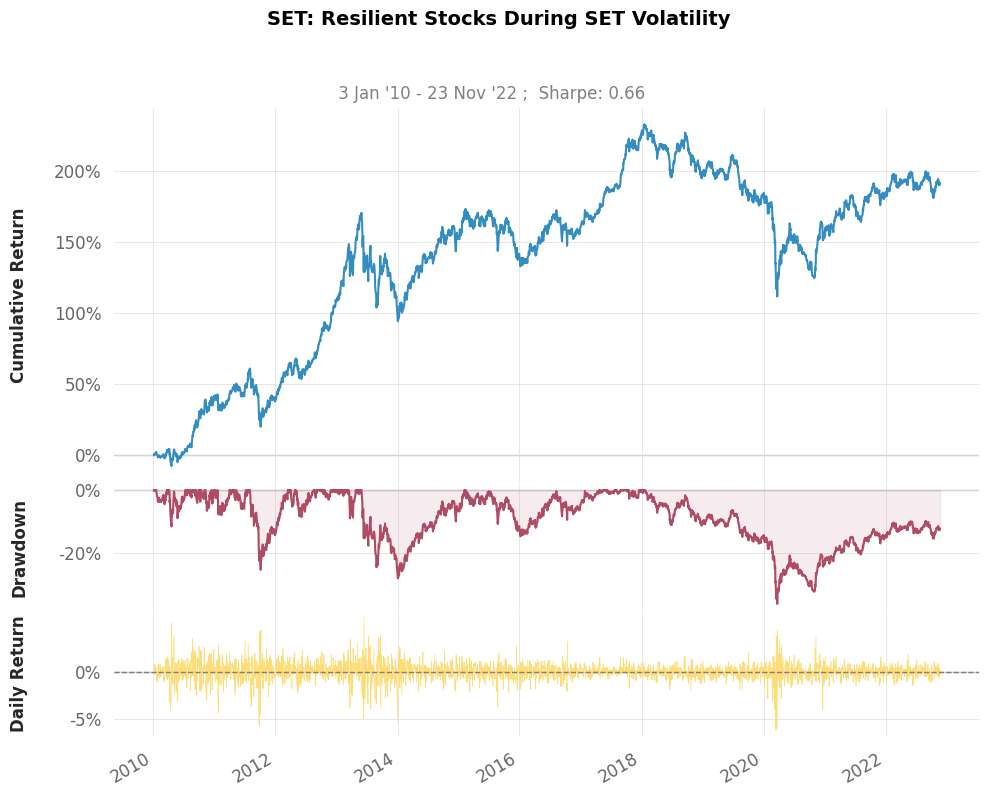

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   190.91%     121.83%
CAGR﹪              8.63%       6.37%

Sharpe              0.66        0.47
Prob. Sharpe Ratio  98.91%      95.09%
Sortino             0.93        0.65
Sortino/√2          0.65        0.46
Omega               1.13        1.13

Max Drawdown        -36.38%     -44.29%
Longest DD Days     1770        1763

Gain/Pain Ratio     0.13        0.09
Gain/Pain (1M)      0.64        0.44

Payoff Ratio        0.96        0.93
Profit Factor       1.13        1.09
Common Sense Ratio  1.21        1.06
CPC Index           0.57        0.55
Tail Ratio          1.08        0.97
Outlier Win Ratio   3.84        3.71
Outlier Loss Ratio  4.35        3.88

MTD                 0.36%       0.97%
3M         

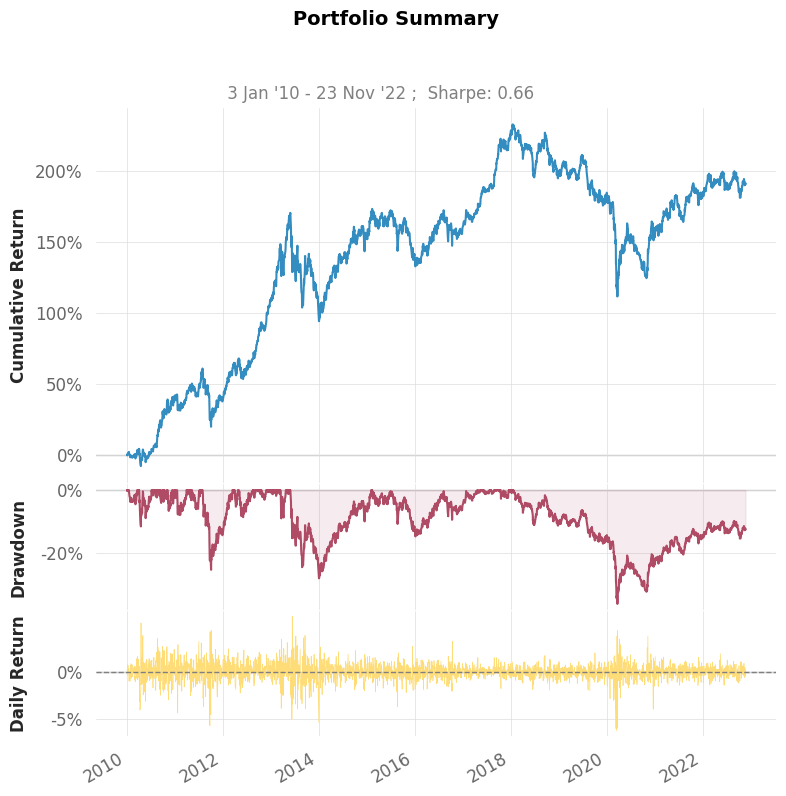

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


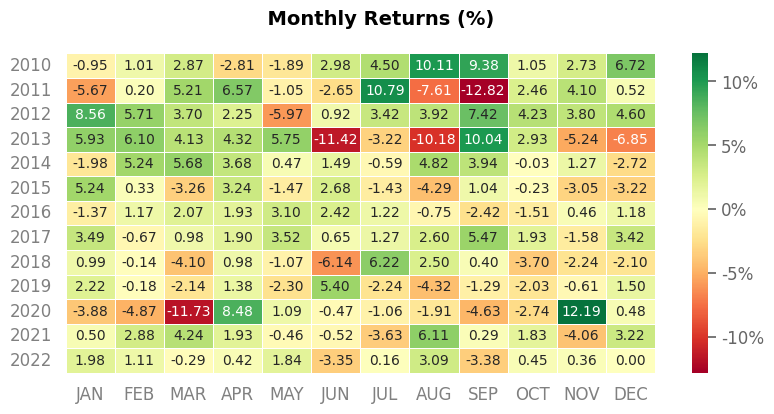

In [ ]:
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(
    summary_df["port_value_with_dividend"], title=f"{UNIVERSE[0]}: {MODEL_NAME}"
)
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

# SET100

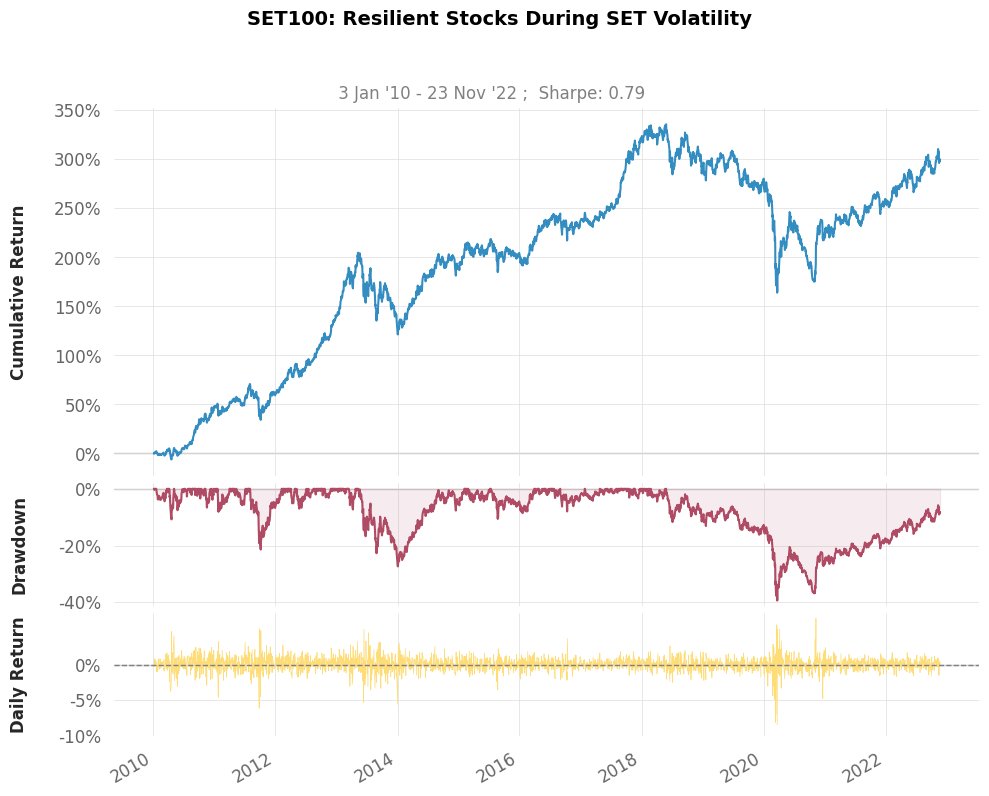

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   299.93%     121.83%
CAGR﹪              11.35%      6.37%

Sharpe              0.79        0.47
Prob. Sharpe Ratio  99.7%       95.09%
Sortino             1.12        0.65
Sortino/√2          0.79        0.46
Omega               1.15        1.15

Max Drawdown        -39.41%     -44.29%
Longest DD Days     1638        1763

Gain/Pain Ratio     0.15        0.09
Gain/Pain (1M)      0.87        0.44

Payoff Ratio        0.98        0.92
Profit Factor       1.15        1.09
Common Sense Ratio  1.24        1.06
CPC Index           0.6         0.54
Tail Ratio          1.07        0.97
Outlier Win Ratio   3.61        3.76
Outlier Loss Ratio  3.87        3.71

MTD                 0.5%        0.97%
3M         

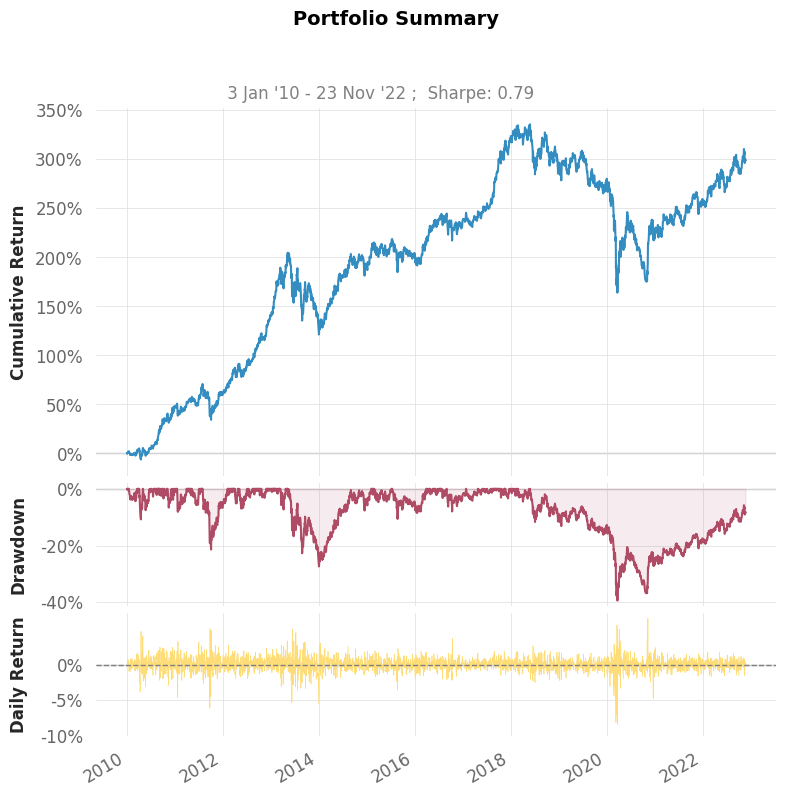

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


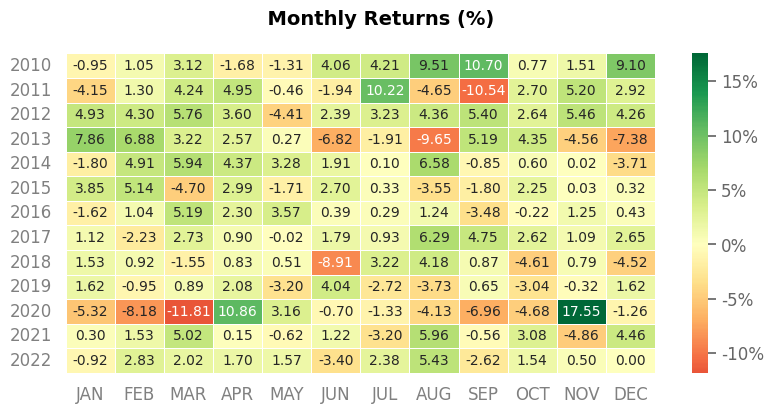

In [ ]:
UNIVERSE = ["SET100"]

ssc = ez.SETSignalCreator(
    start_date=start_data,
    end_date=end_date,
    index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
    field=fld.D_INDEX_CLOSE,
    index_list=[fld.MARKET_SET],
    start_date=start_data,
    end_date=end_date,
)

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)
## Screening Conditions
MODEL_NAME = "Resilient Stocks During SET Volatility"

# price up
close_df = ssc.get_data(field="close", timeframe="daily")
pct_30d_df = ssc.ta.roc(close_df, 30)

# dvd
dvd_yield_df = ssc.get_data(field="dvd_yield", timeframe="daily")

# pe
pe_df = ssc.get_data(field="pe", timeframe="daily")

# de
de_df = ssc.get_data(field="de", timeframe="quarterly")

# value
value_df = ssc.get_data(field="value", timeframe="daily")

# netprofit
net_profit_df = ssc.get_data(field="net_profit", timeframe="quarterly")
# netprofit qoq
net_profit_shift_df = ssc.get_data(field="net_profit", timeframe="quarterly", shift=1)
# netprofit qoqy
net_profit_shift_4_df = ssc.get_data(field="net_profit", timeframe="quarterly", shift=4)

# netprofit growth QoQy
npg_qoqy_df = net_profit_df - net_profit_shift_4_df
# %netprofit growth QoQy
npg_percent_qoqy_df = net_profit_df / net_profit_shift_4_df
# screening condition
# dvd(%) > 0
dvd_cond = dvd_yield_df > 0
# pe < pe avg 3Y
pe_cond = pe_df < pe_df.rolling(window=252).mean()
# de <= 3 (de)
de_cond = de_df <= 3
# avg Val5 > 1,000,000 (value)
value_cond = value_df.rolling(window=15).mean() > 1e6
value_cond_2 = value_df.rolling(window=20).mean() > 2e7  # volume > 2e7
# %price Up In 30 Days > 0
pct_cond = pct_30d_df > 0
# netprofit growth QoQy
npg_qoqy_cond = npg_qoqy_df > 0

signal_cond = (
    dvd_cond & pe_cond & de_cond & value_cond & pct_cond & npg_qoqy_cond & value_cond_2
)

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)


def screen_npg_percent_qoqy_df(
    signal_df: pd.DataFrame, net_proft_growth_qoq_df: pd.DataFrame
) -> pd.DataFrame:
    return pd.DataFrame(
        np.where((signal_df == True), net_proft_growth_qoq_df, np.nan),
        columns=signal_df.columns,
        index=signal_df.index,
    )


# %netprofit growth QoQy
# 10 highest %netprofit growth QoQy
npg_percent_qoqy_df = screen_npg_percent_qoqy_df(signal_df, npg_percent_qoqy_df)
npg_percent_rank_df = ssc.rank(
    factor_df=npg_percent_qoqy_df, quantity=10, ascending=False
)
from ezyquant.utils import is_rebalance_monthly

pos_num = 10
signal_trade = (npg_percent_rank_df > 0) & (npg_percent_rank_df <= pos_num)

# -- rebalance signal --
rebalance_date = is_rebalance_monthly(close_df.index, 31)
signal_trade = signal_trade.mask(~rebalance_date, np.nan)
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(
    np.where(lookahead_signal == -1, -1, signal_trade),
    columns=signal_trade.columns,
    index=signal_trade.index,
)
## Backtest Algorithm
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0:
        return c.target_pct_port(1 / pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0)  # sell
    return 0


# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)
## Visualization
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(
    summary_df["port_value_with_dividend"], title=f"{UNIVERSE[0]}: {MODEL_NAME}"
)
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

# SET50

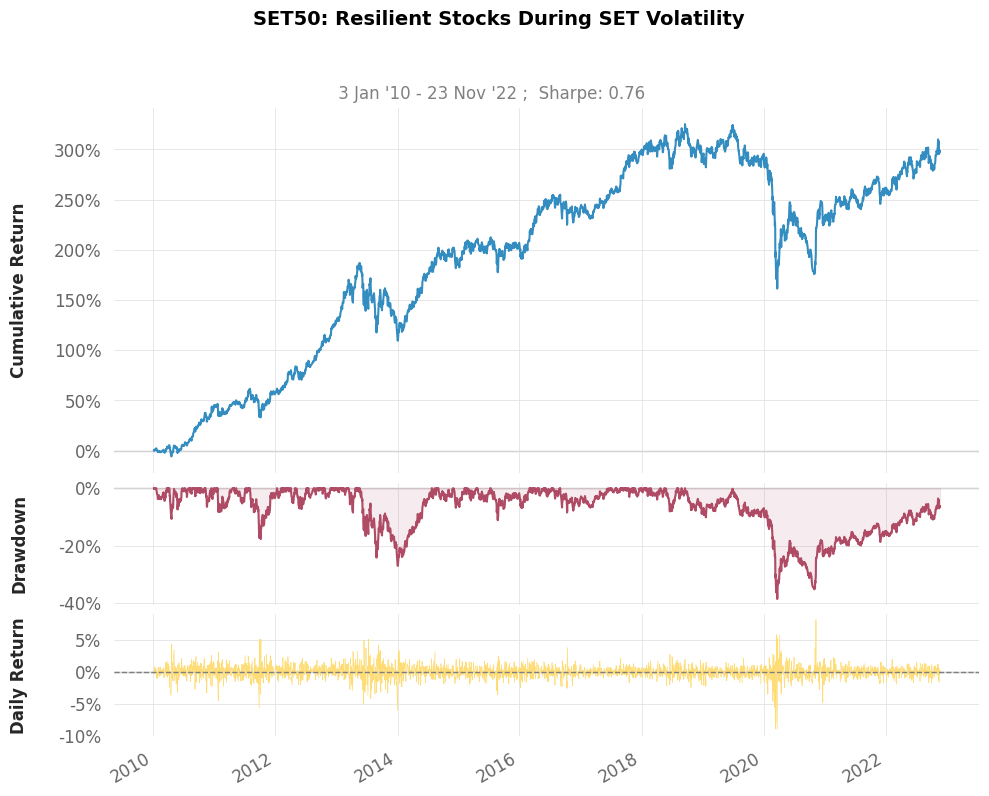

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   298.6%      121.83%
CAGR﹪              11.32%      6.37%

Sharpe              0.76        0.47
Prob. Sharpe Ratio  99.59%      95.09%
Sortino             1.08        0.65
Sortino/√2          0.76        0.46
Omega               1.15        1.15

Max Drawdown        -38.54%     -44.29%
Longest DD Days     1526        1763

Gain/Pain Ratio     0.15        0.09
Gain/Pain (1M)      0.87        0.44

Payoff Ratio        0.97        0.91
Profit Factor       1.15        1.09
Common Sense Ratio  1.2         1.06
CPC Index           0.59        0.54
Tail Ratio          1.05        0.97
Outlier Win Ratio   3.53        3.79
Outlier Loss Ratio  3.86        3.88

MTD                 1.15%       0.97%
3M         

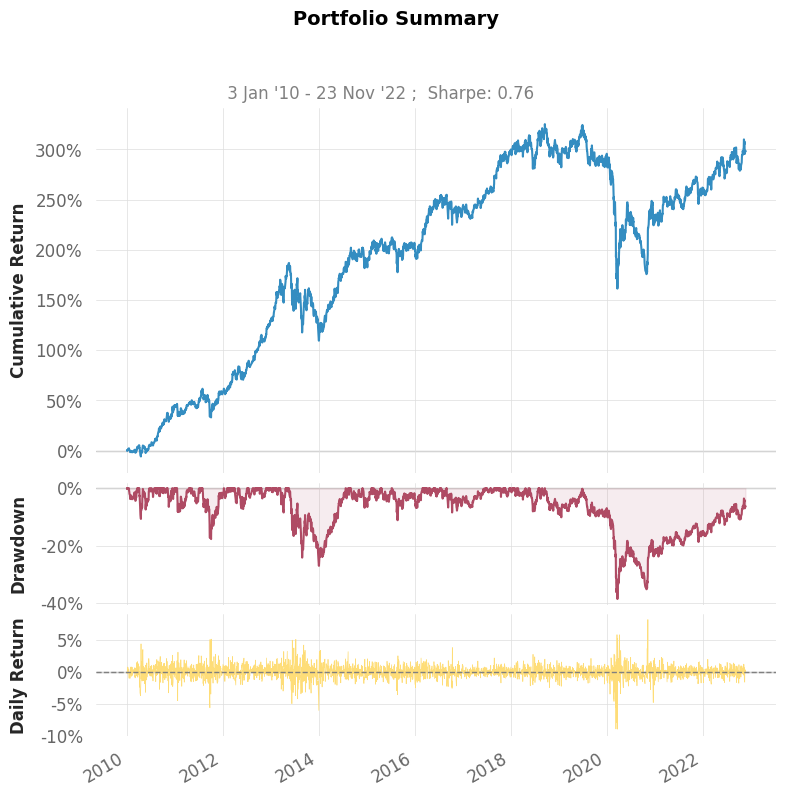

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


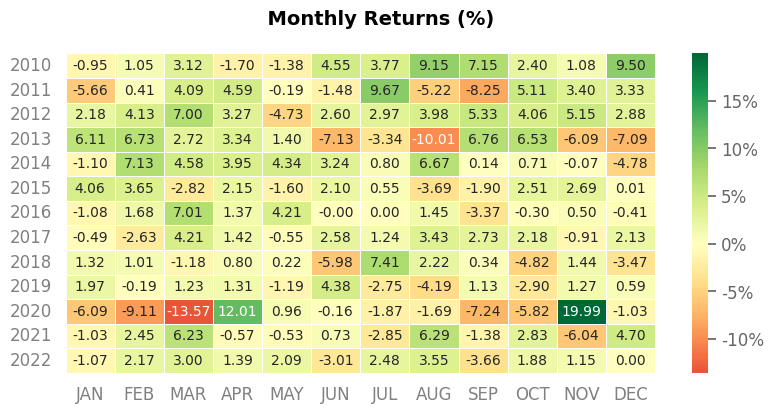

In [ ]:
UNIVERSE = ["SET50"]

ssc = ez.SETSignalCreator(
    start_date=start_data,
    end_date=end_date,
    index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
    field=fld.D_INDEX_CLOSE,
    index_list=[fld.MARKET_SET],
    start_date=start_data,
    end_date=end_date,
)

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)
## Screening Conditions
MODEL_NAME = "Resilient Stocks During SET Volatility"

# price up
close_df = ssc.get_data(field="close", timeframe="daily")
pct_30d_df = ssc.ta.roc(close_df, 30)

# dvd
dvd_yield_df = ssc.get_data(field="dvd_yield", timeframe="daily")

# pe
pe_df = ssc.get_data(field="pe", timeframe="daily")

# de
de_df = ssc.get_data(field="de", timeframe="quarterly")

# value
value_df = ssc.get_data(field="value", timeframe="daily")

# netprofit
net_profit_df = ssc.get_data(field="net_profit", timeframe="quarterly")
# netprofit qoq
net_profit_shift_df = ssc.get_data(field="net_profit", timeframe="quarterly", shift=1)
# netprofit qoqy
net_profit_shift_4_df = ssc.get_data(field="net_profit", timeframe="quarterly", shift=4)

# netprofit growth QoQy
npg_qoqy_df = net_profit_df - net_profit_shift_4_df
# %netprofit growth QoQy
npg_percent_qoqy_df = net_profit_df / net_profit_shift_4_df
# screening condition
# dvd(%) > 0
dvd_cond = dvd_yield_df > 0
# pe < pe avg 3Y
pe_cond = pe_df < pe_df.rolling(window=252).mean()
# de <= 3 (de)
de_cond = de_df <= 3
# avg Val5 > 1,000,000 (value)
value_cond = value_df.rolling(window=15).mean() > 1e6
value_cond_2 = value_df.rolling(window=20).mean() > 2e7  # volume > 2e7
# %price Up In 30 Days > 0
pct_cond = pct_30d_df > 0
# netprofit growth QoQy
npg_qoqy_cond = npg_qoqy_df > 0

signal_cond = (
    dvd_cond & pe_cond & de_cond & value_cond & pct_cond & npg_qoqy_cond & value_cond_2
)

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)


def screen_npg_percent_qoqy_df(
    signal_df: pd.DataFrame, net_proft_growth_qoq_df: pd.DataFrame
) -> pd.DataFrame:
    return pd.DataFrame(
        np.where((signal_df == True), net_proft_growth_qoq_df, np.nan),
        columns=signal_df.columns,
        index=signal_df.index,
    )


# %netprofit growth QoQy
# 10 highest %netprofit growth QoQy
npg_percent_qoqy_df = screen_npg_percent_qoqy_df(signal_df, npg_percent_qoqy_df)
npg_percent_rank_df = ssc.rank(
    factor_df=npg_percent_qoqy_df, quantity=10, ascending=False
)
from ezyquant.utils import is_rebalance_monthly

pos_num = 10
signal_trade = (npg_percent_rank_df > 0) & (npg_percent_rank_df <= pos_num)

# -- rebalance signal --
rebalance_date = is_rebalance_monthly(close_df.index, 31)
signal_trade = signal_trade.mask(~rebalance_date, np.nan)
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(
    np.where(lookahead_signal == -1, -1, signal_trade),
    columns=signal_trade.columns,
    index=signal_trade.index,
)
## Backtest Algorithm
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0:
        return c.target_pct_port(1 / pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0)  # sell
    return 0


# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)
## Visualization
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(
    summary_df["port_value_with_dividend"], title=f"{UNIVERSE[0]}: {MODEL_NAME}"
)
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])